# Manual extraction of LT spectra

This notebook is made to manually extract LT spectra when the more automated version failed.

There are 2 options: get a different trace than the one that was found by the LT pipeline, or do everything from scratch (e.g. if no trace was found by LT)

I used a 2024xmc as an example in the version on GitHub to show both options and give some good starting values to put in the functions. They give slightly different output, mainly due to a sky line being removed as if it were a cosmic ray, but both methods work well.

I put this thing together quickly, and while it works for the purpose it was built, there are some obvious improvements that can be made:
- Improve trace fitting by easily excluding parts of the spine
- Improved wavelengt solution using NIST
- Fixing the hardcoded parts to make it more versatile (should it be used as a basis for another pipeline at some point)
- Documentation

In [1]:
#This notebook is mainly following this: https://learn.astropy.org/tutorials/
#Imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter
from astropy.modeling.models import Gaussian1D, Linear1D
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import ccdproc as ccdp
import pandas as pd

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Functions that will be needed later

#Get wavelength solution from fits file
def get_wl(hdul, verbose=False):
    '''
    hdul: fits extension with the right header
    verbose: print stuff
    
    Returns wavelength solution as a numpy array
    '''
    if verbose:
        wcs=WCS(hdul.header)
        print(wcs)
        print('wavelength is CDELT*np.arange(NAXIS)+CRVAL')
    return hdul.header['CDELT1']*np.arange(hdul.header['NAXIS1'])+hdul.header['CRVAL1']

#Get the response function from the old spectrum by dividing the calib (hdul[4]) and no_calib (hdul[3]) versions or use the calib file
def get_response_func(kind='original', gratset=None, no_calib=None, calib=None, plot_res=False):
    '''
    kind: Choose between getting the response function from the LT fits file or by dividing existing spectra
    gratset: GRATSET keyword in the fits header, needed for kind=original
    no_calib: non calibrated spectrum, needed for kind=spec
    calib: calibrated spectrum, needed for kind=spec
    plot_res: plot the response function
    
    Returns the response function
    '''
    if kind == 'original':
        if gratset == None:
            print('No gratset given, please specify using hdul[0].header["GRATSET"]')
            print('Not returning a response function')
            return None
        print('Getting the response function from the standard files')
        response_function = fits.open(f'calib_data/{gratset}_cal0_1.fits')[0].data[0]
    elif kind == 'spec':
        if ((no_calib == None) | (calib == None)):
            print('Need no_calib and calib to extract the response function, please specify')
            print('Not returning a response function')
            return None
        print('Getting the response function by dividing the calibrated and non-calibrated spectra')
        old_spec_no_calib=no_calib.data[0]
        old_spec_calib=calib.data[0]
        response_function=old_spec_calib/old_spec_no_calib
    else:
        print(f'Specified kind ({kind}) not recoginized. Please use "original" or "spec"')
        print('Not returning a response function')
        return None
    if plot_res:
        plt.plot(wl,response_function)
        plt.show()
    return response_function

def remove_cr(data, show_res=False):
    '''
    data: data from which to remove cosmic rays using lacosmic
    show_res: plot before, after, and mask
    
    Returns the cosmic removed data
    '''
    new_ccd = ccdp.cosmicray_lacosmic(data, gain=1.0, readnoise=2.34, sigclip=10, verbose=True)
    if show_res:
        #Before cosmic ray extraction
        plt.figure(figsize=(20,40))
        plt.imshow(data)
        plt.title('Original')
        plt.show()
        #After cosmic ray extraction
        plt.figure(figsize=(20,40))
        plt.imshow(new_ccd[0].value)
        plt.title('Cosmic rays removed')
        plt.show()
        #Mask
        crmask=np.where(new_ccd[1] == False, 0, 1)
        plt.figure(figsize=(20,40))
        plt.imshow(crmask)
        plt.title('mask')
        plt.show()
    return new_ccd[0].value

#Find the spine according to 1 of 2 methods
#NOTE: For a weak trace the moments method might not work properly, usually the argmax works fine enough
def find_spine(spec, method, axis, region=None, plot_result=False, figsize=(8,3)):
    '''
    spec: 2D spectrum to find the spine of
    method: Method to find the spine: argmax (max values) or moments
    axis: expected orientation of the spine (0 = horizontal)
    region: region in which to search for the spine
    plot_result: show the found spine
    figsize: figure size for plot_result
    
    Returns spine and indices
    '''
    methods = ['argmax', 'moments']
    if method not in methods:
        print(f'Error: mehtod {method} not recognised')
        print(f'Please use one from {methods}')
        return
    if method == 'argmax': #Method 1
        if region is not None:
            spec = spec[region[0], region[1]]
            slice_offset = region[axis].start
        else:
            slice_offset = 0
        spine = np.argmax(spec, axis=axis) + slice_offset
    elif method == 'moments': #Method 2
        if region is not None:
            spec = spec[region[0], region[1]]
        if axis == 0:
            yaxis = np.repeat(np.arange(region[axis].start, region[axis].stop)[:, None], spec.shape[1], axis=1)
        else:
            yaxis = np.repeat(np.arange(region[axis].start, region[axis].stop)[None, :], spec.shape[0], axis=0)
        background = np.median(spec)
        spine = np.average(yaxis, axis=axis, weights=spec - background)
    bad_vals = (spine < region[axis].start) | (spine > region[axis].stop)
    indices = np.arange(len(spine))
    if region != None:
        if region[1].start != None:
            indices += region[1].start
    if plot_result:
        fig = plt.figure(figsize=figsize)
        plt.scatter(indices[~bad_vals], spine[~bad_vals], marker='x', alpha=0.5)
        plt.ylabel('spine')
        plt.xlabel('index')
        plt.show()
    return spine[~bad_vals], indices[~bad_vals]

#Fit a trace to the spine
def fit_trace(spine, indices, degree=2, plot_result=False, figsize=(8,4), xlim=None, ylim=None):
    '''
    spine: found spine from find_spine()
    indices: indices from find_spine()
    degree: degree of the fit
    plot_result: plot the model and spine
    figsize: set plot size
    xlim: set plot x-axis
    ylim: set plot y-axis
    
    Returns the trace model
    '''
    polymodel = Polynomial1D(degree=degree)
    linfitter = LinearLSQFitter()
    model = linfitter(polymodel, indices, spine)
    if plot_result:
        fig, axs = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1], sharex=True)
        axs[0].plot(indices, spine, 'x', alpha=0.5)
        axs[0].plot(indices, model(indices), color='r')
        axs[0].set_ylabel('spine')
        axs[0].set_title('Trace')
        axs[1].plot(indices, spine - model(indices), 'x')
        axs[1].set_ylabel("Residual (data-model)")
        axs[1].set_xlabel('index')
        axs[1].grid(alpha=0.5)
        axs[1].set_xlim(xlim)
        axs[1].set_ylim(ylim)
        plt.tight_layout()
        plt.show()
    return model

#extract the trace
#extract_tot is the total region to extract, extract_spec is the spectrum region, extract_bg is the background region(s)
def extract_trace(spec, model, extract_tot, extract_spec, extract_bg, axis, extract_method='avg', plot_result=False, figsize=(16,2)):
    '''
    spec: 2D spectrum
    model: trace model from fit_trace()
    extract_tot: total spatial region to use in an extraction(if the trace is in the x direction, how many y values around the trace are needed?)
    extract_spec: total spatial region to use for the spectrum
    extract_bg: total spatial regions to use for the background
    axis: direction of the trace (0 = horizontal)
    extract_method: how to add the values for extract_spec: avg = sum/len(spatial direction spectrum)
                                                            weighted avg = fit Gaussian to the trace for each column and use those as a weight measure
    plot_result: show plots of the extraction steps, good when messing around with the other values
    figsize: figure size of the plots
    
    Returns the extracted 1D spectrum
    '''
    extract_methods = ['avg', 'weighted avg']
    if extract_method not in extract_methods:
        print(f'Error: extraction method {extract_method} not recognised')
        print(f'Please use one from {extract_methods}')
        return
    if axis == 1:
        spec = np.transpose(spec)
    vals = np.arange(np.shape(spec)[1])
    trace_center = model(vals)
    cutouts = np.array([spec[int(yval)+extract_tot[0]:int(yval)+extract_tot[1], _] for yval, _ in zip(trace_center, vals)])
    mean_trace_profile = (cutouts).mean(axis=0)
    trace_profile_xaxis = np.arange(extract_tot[0], extract_tot[1])
    lmfitter = LevMarLSQFitter()
    guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=mean_trace_profile-mean_trace_profile[0])
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)+mean_trace_profile[0]
    if plot_result:
        plt.plot(trace_profile_xaxis, mean_trace_profile, label='data')
        plt.plot(trace_profile_xaxis, model_trace_profile, label='Gaussian model')
        plt.plot(extract_spec, [0, 0], 'k', label='spec')
        for _ in range(len(extract_bg)):
            if _ == 0:
                label = 'background'
            else:
                label = None
            plt.plot(extract_bg[_], [0, 0], 'k:', label=label)
            plt.plot(np.arange(extract_bg[_][0], extract_bg[_][1]),
                     cutouts[:, extract_bg[_][0]-extract_tot[0]:extract_bg[_][1]-extract_tot[0]].mean(axis=0),
                     'k', lw=2)
        plt.plot(np.arange(extract_spec[0], extract_spec[1]),
                 cutouts[:, extract_spec[0]-extract_tot[0]:extract_spec[1]-extract_tot[0]].mean(axis=0), 'k', lw=2)
        plt.legend()
        plt.xlabel("Distance from center")
        plt.ylabel("Average source profile")
        plt.title('Extraction regions')
        plt.grid(alpha=0.5)
        plt.show()
    if extract_method == 'avg':
        average_spectrum = cutouts[:, extract_spec[0]-extract_tot[0]:extract_spec[1]-extract_tot[0]].mean(axis=1)
        if len(extract_bg) > 0:
            for _ in range(len(extract_bg)):
                if _ == 0:
                    bkg = cutouts[:, extract_bg[_][0]-extract_tot[0]:extract_bg[_][1]-extract_tot[0]].mean(axis=1)
                else:
                    bkg += cutouts[:, extract_bg[_][0]-extract_tot[0]:extract_bg[_][1]-extract_tot[0]].mean(axis=1)
            bkg = bkg/len(extract_bg)
    elif extract_method == 'weighted avg':
        average_spectrum = np.array([np.average(spec[int(yval)+extract_spec[0]:int(yval)+extract_spec[1], ii],
                                                weights=mean_trace_profile[extract_spec[0]-extract_tot[0]:extract_spec[1]-extract_tot[0]])
                                     for yval, ii in zip(trace_center, vals)])
        if len(extract_bg) > 0:
            for _ in range(len(extract_bg)):
                if _ == 0:
                    bkg = np.array([np.average(spec[int(yval)+extract_bg[_][0]:int(yval)+extract_bg[_][1], ii],
                                               weights=mean_trace_profile[extract_bg[_][0]+extract_tot[0]:extract_bg[_][1]+extract_tot[0]])
                                    for yval, ii in zip(trace_center, vals)])
                else:
                    bkg += np.array([np.average(spec[int(yval)+extract_bg[_][0]:int(yval)+extract_bg[_][1], ii],
                                                weights=mean_trace_profile[extract_bg[_][0]-extract_tot[0]:extract_bg[_][1]-extract_tot[0]])
                                     for yval, ii in zip(trace_center, vals)])
            bkg = bkg/len(extract_bg)
    if plot_result:
        plt.title('1D spec')
        if len(extract_bg) > 0:
            plt.plot(average_spectrum - bkg)
        else:
            plt.plot(average_spectrum)
        plt.xlabel('index')
        plt.ylabel('flux (ADU)')
        plt.show()
    if len(extract_bg) > 0:
        return average_spectrum - bkg
    else:
        return average_spectrum

#Find a wavelength solution using an arc frame
def extract_wl(arc_frame, trace_mod, npix=5, plot_result=False):
    '''
    arc_frame: arc frame to get the wavelength solution from(hard-coded Xe for the LT at the moment)
    trace_mod: trace model for the science target, the wavelength solution should be extracted along the same trace
    npix: measure for how many pixels the code is allowed to stray from the 1st guesses
    plot_results: show results, good for checking the correct line identification
    
    Returns the found wavelength solution
    '''
    arc = fits.open(arc_frame)
    i = 1
    while True:
        try:
            if arc[0].header[f'LAMP{i}SET'] == True:
                print(f"Lamp type: {arc[0].header[f'LAMP{i}TYP']}")
            i += 1
        except:
            break
    if plot_result:
        fig = plt.figure(figsize=(20,40))
        plt.imshow(arc[0].data, vmin=0, vmax=500)
        plt.plot(indices, trace_mod(indices), color='r')
        plt.show()
    #Step 1: extract arc along the trace
    reg_tot = (-10, 10)
    reg_spec = (-3, 5)
    regs_bck = ()
    axis = 0
    extract_method = 'weighted avg'
    extracted_arc = extract_trace(arc[0].data, trace_mod, reg_tot, reg_spec, regs_bck, axis, extract_method, plot_result=False)
    #Step 2: Find the peaks and identify lines
    wls_file = Path('calib_data/Xe_lines.csv')
    print(f'Using {wls_file} (Currently hardcoded!)')
    wls_to_find = pd.read_csv(wls_file, header=0)
    #Improve first guesses (npix = how much it may vary) (astropy tutorial goes further using NIST to improve the solution, not doing that here now)
    xaxis = np.arange(len(extracted_arc))
    wls_to_find['improved_guess'] = [np.average(xaxis[g-npix:g+npix], weights=extracted_arc[g-npix:g+npix] - np.median(extracted_arc))
                                      for g in wls_to_find.first_guess]
    if plot_result:
        fig = plt.figure(figsize=(20,4))
        plt.plot(extracted_arc)
        m = max(extracted_arc)
        for i in range(len(wls_to_find)):
            plt.axvline(wls_to_find.first_guess.loc[i], color='k', alpha=0.6, ymax=0.8)
            plt.axvline(wls_to_find.improved_guess.loc[i], color='r', alpha=0.6, ymax=0.7)
            plt.text(wls_to_find.first_guess.loc[i], 1.05*m, f'{wls_to_find.wl.loc[i]:.2f}', rotation=270)
        plt.ylim(-500, 1.3*m)
        plt.xlim(0, len(extracted_arc))
        plt.title('Line guesses')
        plt.show()
    #Step 3: fit and interpolate the wavelength solution
    fitter = LinearLSQFitter()
    wlmodel = Polynomial1D(degree=3)
    linfit_wlmodel = fitter(model=wlmodel, x=wls_to_find.improved_guess, y=wls_to_find.wl)
    wl = linfit_wlmodel(xaxis)
    if plot_result:
        plt.plot(wls_to_find.improved_guess, wls_to_find.wl, 'o')
        plt.plot(xaxis, wl, '-')
        plt.ylabel("$\lambda(x)$")
        plt.xlabel("x (pixels)")
        plt.title('wavelength solution fit')
        plt.show()
        fig = plt.figure(figsize=(20,4))
        plt.plot(wl, extracted_arc)
        m = max(extracted_arc)
        for i in range(len(wls_to_find)):
            plt.axvline(wls_to_find.wl.loc[i], color='k', alpha=0.6, ymax=0.8)
            plt.text(wls_to_find.wl.loc[i], 1.05*m, f'{wls_to_find.wl.loc[i]:.2f}', rotation=270)
        plt.ylim(-500, 1.3*m)
        plt.xlabel(r'wavelength ($\AA$)')
        plt.title('Arc with wavelength solution')
        plt.show()
        residuals = np.array(wls_to_find.wl) - linfit_wlmodel(wls_to_find.improved_guess)
        plt.hist(residuals, histtype='stepfilled')
        plt.title('residuals')
        plt.show()
        plt.plot(wls_to_find.wl, residuals, 'x')
        plt.xlabel("Pixel Coordinate")
        plt.ylabel("Wavelength residual (data minus model)")
        plt.show()
    return wl

#Rebin the spectrum in the regular LT format
def rebin_spec(spec, wl, plot_result=False):
    '''
    spec: spectrum
    wl: wavelength solution
    plot_result: show the original and rebinned spectra
    
    Returns the rebinned spectrum and wavelength solution
    '''
    #The rebinning takes the spectrum between 4020 and 8095-4020 Angstrom, and divides it in equally spaced points every 9.2ish Angstrom.
    #Make new wavelength axis
    wl_new = np.linspace(4020, 8095, int(np.round((8095-4020)/9.2, 0)))
    #Interpolate the spectrum value at each new wl
    spec_new = np.interp(wl_new, wl, spec)
    if plot_result:
        fig = plt.figure(figsize=(20,4))
        plt.plot(wl, spec, alpha=0.5, label='Original')
        plt.plot(wl_new, spec_new, label='rebinned')
        plt.legend()
        plt.show()        
    return spec_new, wl_new

#Starter of a spectrum figure
def start_fig(lines=None, names=None, z=0, xlim=(3900, 8200), ylim=(-0.2, 1.2), figsize=(10,3)):
    '''
    lines: element lines to plot
    names: names for the element lines
    z: shift the lines by this redshift
    xlim: set wavelength axis to show
    ylim: set flux axis to show
    figsize: set figure size
    
    Returns the figure for further use before it is shown
    '''
    fig = plt.figure(figsize=figsize)
    plt.xlabel(r'Observed wavelength ($\AA$)')
    plt.xlabel('Normalized flux')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if lines != None:
        if len(lines) != len(names):
            print('Error: different amount of lines and line names given, not plotting lines')
        else:
            for i in range(len(lines)):
                plt.axvline(lines[i]*(1+z), color='k', alpha=0.5, ls=':')
                plt.text(lines[i]*(1+z), 1.1, names[i], ha='left', fontsize=14)
    return fig

#Correct spectrum for observing at a certain airmass
def correct_airmass(a, airmass, verbose=False):
    '''
    a: 1D spectrum
    airmass: airmass at which the spectrum was taken
    verbose: plot the correction
    
    Returns the corrected spectrum
    '''
    #Find the correct correction file
    airmass_corrections = np.sort([float(_.name.split('.txt')[0]) for _ in Path('./CorrectionFiles').glob('*.txt')])
    cor_file = Path(f'./CorrectionFiles/{airmass_corrections[np.argmin(np.abs(airmass_corrections-airmass))]}.txt')
    if verbose:
        print(f'Correcting flux for airmass {airmass} using {cor_file}')
    s = pd.read_csv(cor_file, header=None, comment='#', delim_whitespace=True)
    s.rename(columns={0:'wl', 1:'scale_fac'}, inplace=True)
    if verbose:
        fig = plt.figure(figsize=(20, 4))
        plt.plot(s.wl, s.scale_fac)
        plt.title('Correction')
        plt.xlabel(r'Wavelength ($\AA$)')
        plt.ylabel('scale factor')
        plt.show()
    #Do the rescaling and then normalize again
    for q in range(len(a)):
        find = np.argmin(abs(s.wl-a.loc[q, 'wl']))
        a.loc[q, 'scaled_flux'] =  a.loc[q, 'flux']/s.loc[find, 'scale_fac']
    if verbose:
        fig = plt.figure(figsize=(20, 4))
        plt.title('Airmass correction')
        plt.plot(a.wl, a.flux, label='uncorrected')
        plt.plot(a.wl, a.scaled_flux/a.scaled_flux.max(), alpha=0.5, ls='--', label='corrected')
        plt.xlabel(r'Wavelength ($\AA$)')
        plt.ylabel('scaled flux')
        plt.legend()
        plt.show()
    a.flux = a.scaled_flux/a.scaled_flux.max()
    a.drop(columns='scaled_flux', inplace=True)
    return a

#Apply Cosmic ray removal if desired
#WARNING: MAY ALSO REMOVE HOST LINES!!!
def CRReject(spec, window=37, verbose=False):
    '''
    spec: spectrum
    window: measure for how strong the outlier has to be to be rejected
    verbose: plot result
    
    Returns the corrected spectrum
    '''
    x = spec.wl
    y = spec.flux
    for j in range(len(x)-window):
        region = y[j:j+window+1]        
        magic_index = int(j+np.ceil(window/2))
        if y[magic_index] > (np.median(region) + 2.5*np.std(region)):
            y[magic_index] = np.median(region)
    # deal with the beginning
    region = y[:window+1]   
    for idx in range(len(region)):
        if y[idx] > (np.median(region) + 5*np.std(region)):
            y[idx] = np.median(region)
    # deal with the beginning
    region = y[j-window:]   
    for idx in range(j-window, len(region)):
        if y[idx] > (np.median(region) + 5*np.std(region)):
            y[idx] = np.median(region)        
    if verbose:
        fig = plt.figure(figsize=(20, 4))
        plt.title('Cosmic ray correction')
        plt.plot(spec.wl, spec.flux, label='uncorrected')
        plt.plot(spec.wl, y, alpha=0.5, ls='--', label='corrected')
        plt.xlabel(r'Wavelength ($\AA$)')
        plt.ylabel('scaled flux')
        plt.legend()
        plt.show()
    spec.flux = y
    return spec

#Basically does what Simon's pipeline does
def final_processing(spec_df, header, airmass_correction=False, cr_correction=False, verbose=False):
    '''
    spec_df: spectrum in pandas dataframe format
    header: spectrum header
    airmass_correction: apply an airmass correction before saving?
    cr_correction: apply a cosmic ray correction before saving?
    verbose: plot correction results and give a summary of the result
    
    Returns nothing
    '''
    name = header['OBJECT']
    dateobs = header['DATE-OBS']
    date = dateobs.split('T')[0]
    mjd = header['MJD']
    #Apply the requested corrections
    if airmass_correction:
        airmass = hdul[0].header['AIRMASS']
        spec_df = correct_airmass(spec_df, airmass, verbose=verbose)
    if cr_correction:
        spec_df = CRReject(spec_df, verbose=verbose)
    #Save the result
    saveloc = f'OutputSpectra/{name}_{date}.w.text'
    if verbose:
        print(f'Name:\t\t{name}\nobsdate:\t{dateobs}\nmjd:\t\t{mjd}\nSaving in {saveloc}')
    f = open(saveloc, 'w') #Overwrite previous instance if it is there
    f.write(f'# {dateobs} {mjd}\n')
    f.close()
    spec_df.to_csv(saveloc, header=False, index=False, sep=' ', mode='a')
    return

## Assuming a trace was found but you want another one --> Use the calibrated files to extract the correct trace

In [3]:
#find files
main_path = Path('InputSpectra')
files = [_ for _ in main_path.glob('v_e*.fits')]
files.sort()
print('found the following files:')
for i in files:
    print(i.name)

found the following files:
v_e_20241012_19_1_0_2.fits


In [4]:
#Choose which spectrum to work with
w = 0

#Check internal structure (should have extensions 0-5)
hdul = fits.open(files[w])
hdul.info()

Filename: InputSpectra/v_e_20241012_19_1_0_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  L1_IMAGE      1 PrimaryHDU     256   (1024, 254)   int16 (rescales to float32)   
  1  LSS_NONSS     1 ImageHDU       269   (443, 209)   float32   
  2  SPEC_NONSS    1 ImageHDU       269   (443, 1)   float32   
  3  SPEC_SS       1 ImageHDU       285   (443, 1)   float32   
  4  NORMFLUX      1 ImageHDU       287   (443, 1)   float32   
  5  FLUX          1 ImageHDU       288   (443, 1)   float32   


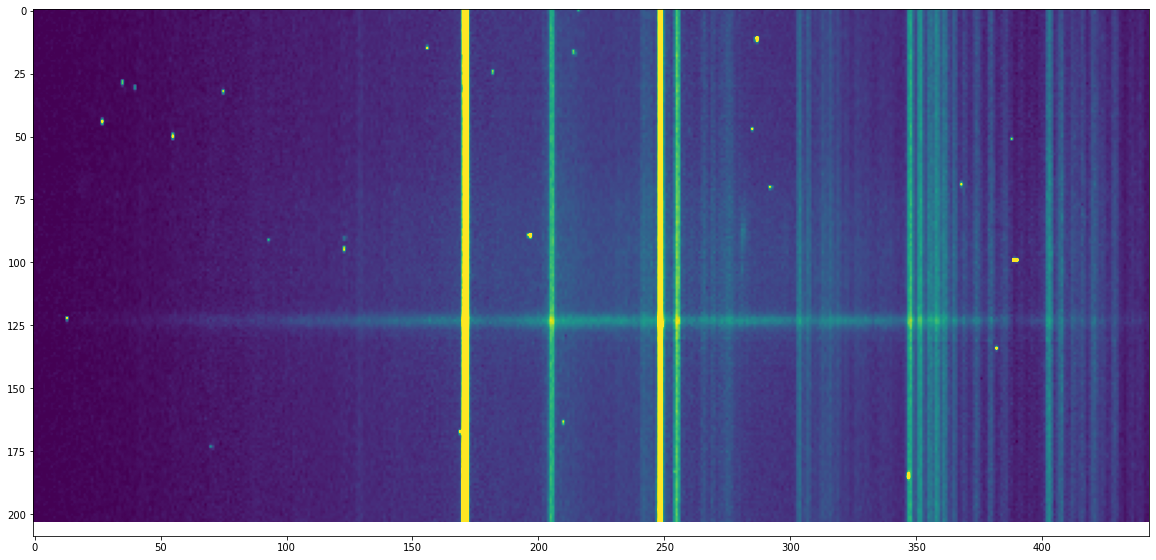

In [5]:
#Original spec
fig = plt.figure(figsize=(20,40))
plt.imshow(hdul[1].data, vmin=0, vmax=500)
plt.show()

In [6]:
#Get the wavelength solution
wl = get_wl(hdul[1], verbose=False)

In [7]:
#Get the response function from the files LT uses
response_function = get_response_func(kind='original', gratset=hdul[0].header['GRATSET'], plot_res=False)
#Alternatively, get the response function from the old spectrum by dividing the calib (hdul[4]) and no_calib (hdul[3]) versions
#response_function = get_response_func(kind='spec', no_calib=hdul[3], calib=hdul[4], plot_res=False)

#They should give the same shape, just different normalization (which is taken care of later anyway)

Getting the response function from the standard files


In [8]:
#Remove cosmic rays
cleaned_2D_spec = remove_cr(hdul[1].data, show_res=False)

Starting 4 L.A.Cosmic iterations
Iteration 1:
89 cosmic pixels this iteration
Iteration 2:
10 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration


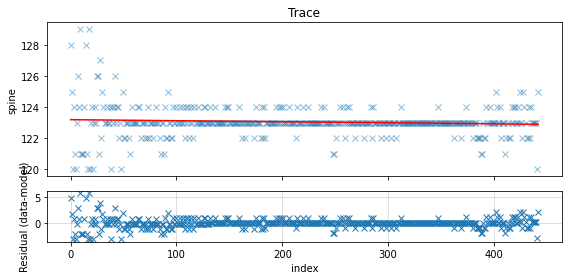

In [9]:
#Choose the cutout (center on the approximate location of the desired spectrum)

#Set in which x and y values to search for the spine (None means use everything)
xlow = None
xhigh = None
ylow = 120
yhigh = 130
#set axis to fit (0 = horizontal)
axis = 0
#For faint spectra using argmax works better (Other method = moments)
method = 'argmax'
#Set the degree of the polynomial to fit to the trace
degree = 1

#Find the spine, then the trace
spine, indices = find_spine(cleaned_2D_spec, method, axis, [slice(ylow, yhigh), slice(xlow, xhigh)], plot_result=False)
trace_mod = fit_trace(spine, indices, degree, plot_result=True)

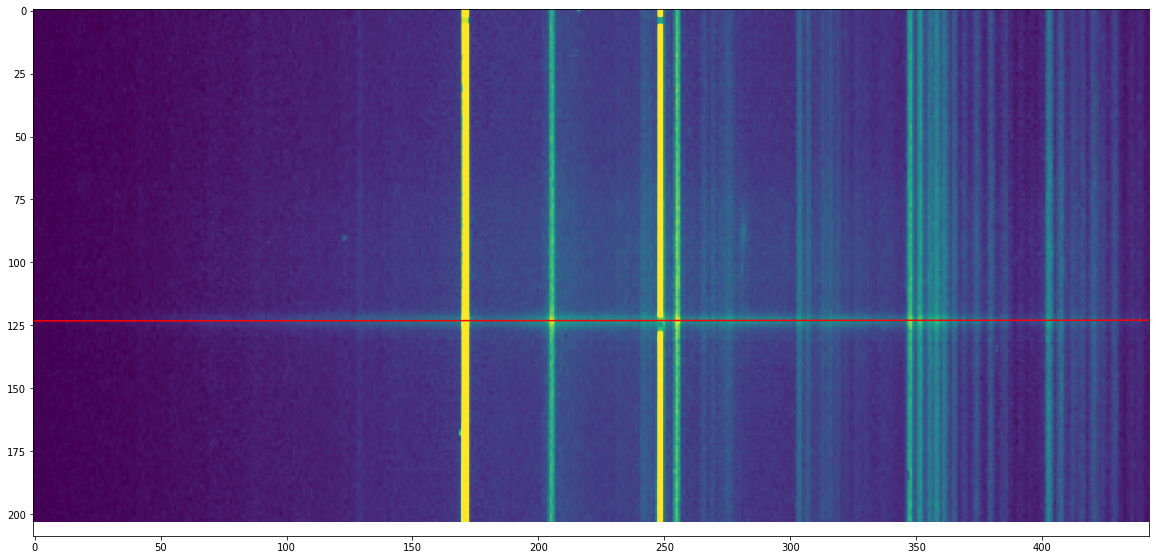

In [10]:
#Show the cleaned 2D spec with the trace in red
fig = plt.figure(figsize=(20,40))
plt.imshow(cleaned_2D_spec, vmin=0, vmax=500)
#plt.scatter(indices, spine, marker='x', color='r', alpha=0.5)
plt.plot(indices, trace_mod(indices), color='r')
plt.show()

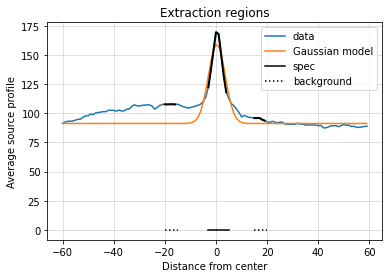

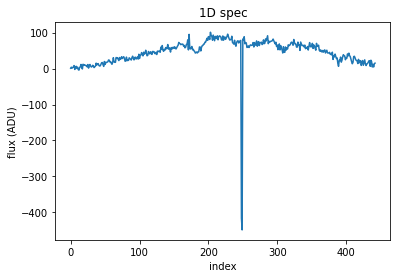

In [11]:
#Extract the spectrum

#Set regions around the trace to extract: total region , spec region, background region(s) --> Trace is at 0
reg_tot = (-60, 60)
reg_spec = (-3, 5)
regs_bck = ((-20, -15), (15, 20))
axis = 0
#2 ways to get the trace: avg or weighted avg
extract_method = 'weighted avg'

extracted_spec = extract_trace(cleaned_2D_spec, trace_mod, reg_tot, reg_spec, regs_bck, axis, extract_method, plot_result=True)

In [12]:
#Flux calibrate and normalize spec
calib_spec = extracted_spec*response_function/np.max(extracted_spec*response_function)

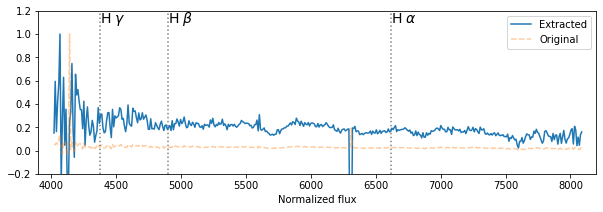

In [13]:
#Plot the spectrum and add line markers as desired
lines = [6563, 4861, 4341]
names = [r'H $\alpha$', r'H $\beta$', r'H $\gamma$']
z = 0.008

fig = start_fig(lines, names, z)
plt.plot(wl, calib_spec, label='Extracted')
plt.plot(wl, hdul[4].data[0]/np.max(hdul[4].data[0]), label='Original', alpha=0.4, ls='--')
plt.legend()
plt.show()

### Further processing akin to Simon's QuickSPRATPipeline

Correcting flux for airmass 1.393748 using CorrectionFiles/1.4.txt


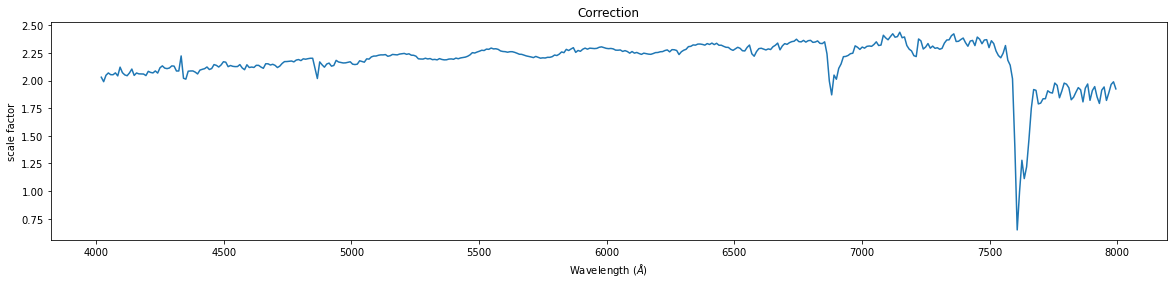

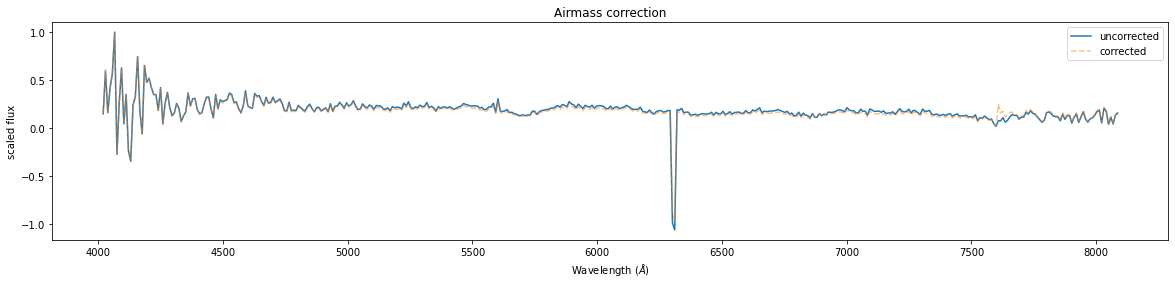

Name:		2024xmc
obsdate:	2024-10-13T05:35:25.232
mjd:		60596.232931
Saving in OutputSpectra/2024xmc_2024-10-13.w.text


In [14]:
#First put the spectrum in a pandas df for easy handling
spec_df = pd.DataFrame(np.array([wl, calib_spec]).transpose(), columns=['wl', 'flux'])

#Choose whether airmass and/or cosmic ray correction should be applied before saving the result
#WARING: CR CORRECTION MAY ALSO REMOVE HOST LINES!!! (Already done a proper one in the 2D version anyway so normally not needed)
airmass_correction = True
cr_correction = False

#This also automatically saves the final result
final_processing(spec_df, hdul[0].header, airmass_correction, cr_correction, verbose=True)

## No auto-extract was performed or you want to do your own (e.g. no ..._2.fits) --> Work from L1_image (extension 0)

Quick explanation: L1_image (extension 0) is the image after bias and flat correction. To get LSS_NONSS (extension 1) the following things have to be done:
- Find a trace
- Get the wavelength solution (requires an arc frame, for the LT data that's v\_a\_(date)\_(science exposure + 1)\_1\_0\_1.fits)
- Rebin the spectrum to a linear wavelength solution
- Cut off the part of the CCD that isn't illuminated
- Rotate the spectrum so that the trace is horizontal --> Traces in LSS_NONSS should be on a single row (more or less)

The last 2 things do not have to be done, LT just does it to save space. The rebinning can also be done after extracting the trace, making things much simpler. After that, it's business as usual.

In [15]:
#find files
main_path = Path('InputSpectra')
files = [_ for _ in main_path.glob('v_e*.fits')]
files.sort()
print('found the following files:')
for i in files:
    print(i.name)

found the following files:
v_e_20241012_19_1_0_2.fits


In [16]:
#Choose which to work with
w = 0

#Check internal structure
hdul = fits.open(files[w])
hdul.info()

Filename: InputSpectra/v_e_20241012_19_1_0_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  L1_IMAGE      1 PrimaryHDU     256   (1024, 254)   int16 (rescales to float32)   
  1  LSS_NONSS     1 ImageHDU       269   (443, 209)   float32   
  2  SPEC_NONSS    1 ImageHDU       269   (443, 1)   float32   
  3  SPEC_SS       1 ImageHDU       285   (443, 1)   float32   
  4  NORMFLUX      1 ImageHDU       287   (443, 1)   float32   
  5  FLUX          1 ImageHDU       288   (443, 1)   float32   


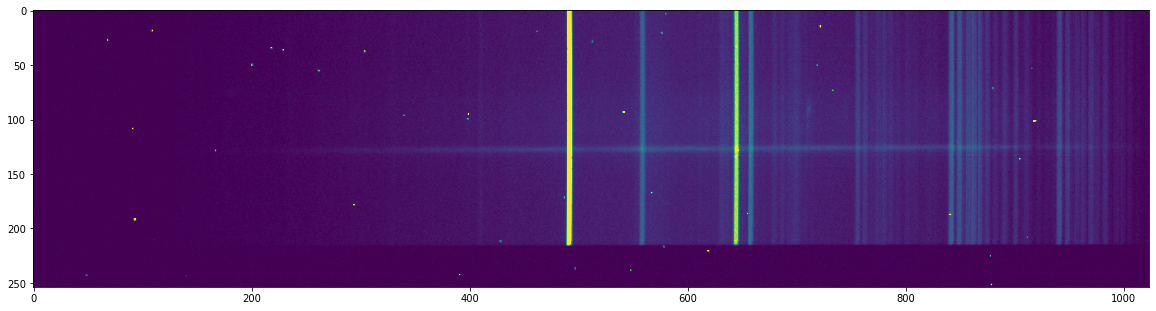

In [17]:
#Original spec
fig = plt.figure(figsize=(20,40))
plt.imshow(hdul[0].data, vmin=0, vmax=500)
plt.show()

In [18]:
#Get the response function from the files LT uses
response_function = get_response_func(kind='original', gratset=hdul[0].header['GRATSET'], plot_res=False)

Getting the response function from the standard files


In [19]:
#Remove cosmic rays
cleaned_2D_spec = remove_cr(hdul[0].data, show_res=False)

Starting 4 L.A.Cosmic iterations
Iteration 1:
131 cosmic pixels this iteration
Iteration 2:
4 cosmic pixels this iteration
Iteration 3:
4 cosmic pixels this iteration
Iteration 4:
4 cosmic pixels this iteration


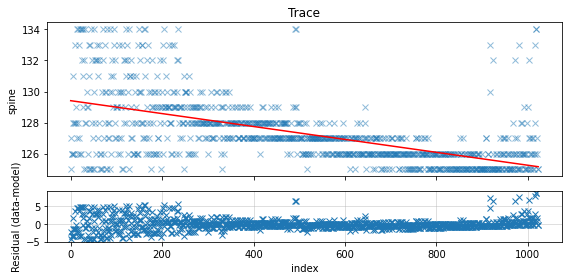

In [20]:
#Choose the cutout (center on the approximate location of the desired spectrum)

#Set in which x and y values to search for the spine (None means use everything)
xlow = None
xhigh = None
ylow = 125
yhigh = 135
#set axis to fit (0 = horizontal)
axis = 0
#For faint spectra using argmax works better (Other method = moments)
method = 'argmax'
#Set the degree of the plynomial to fit to the trace
degree = 1

#Find the spine, then the trace
spine, indices = find_spine(cleaned_2D_spec, method, axis, [slice(ylow, yhigh), slice(xlow, xhigh)], plot_result=False)
trace_mod = fit_trace(spine, indices, degree, plot_result=True)

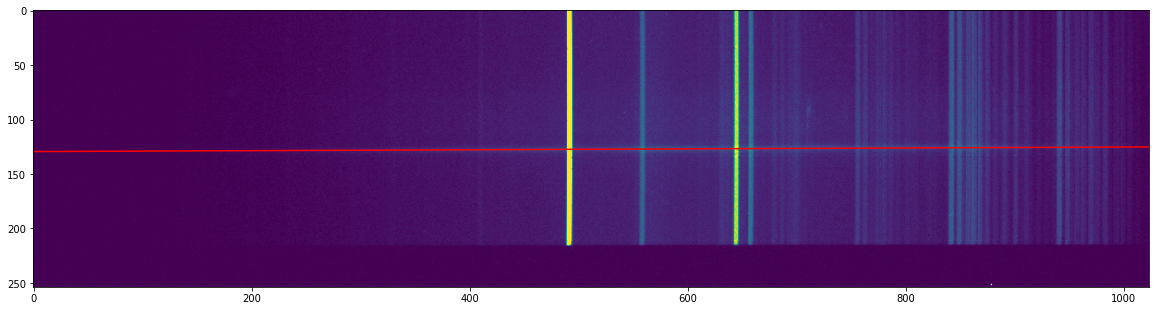

In [21]:
#Show the cleaned 2D spec with the trace in red
fig = plt.figure(figsize=(20,40))
plt.imshow(cleaned_2D_spec, vmin=0, vmax=500)
#plt.scatter(indices, spine, marker='x', color='r', alpha=0.5)
plt.plot(indices, trace_mod(indices), color='r')
plt.show()

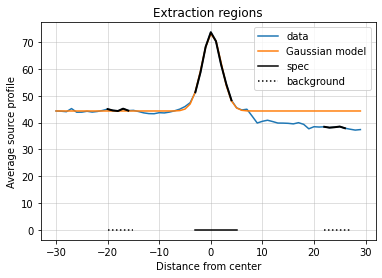

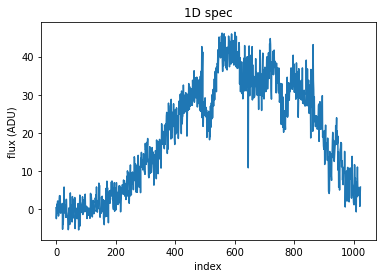

In [22]:
#Extract the spectrum

#Set regions around the trace to extract: total region , spec region, background region(s) --> Trace is at 0
reg_tot = (-30, 30)
reg_spec = (-3, 5)
regs_bck = ((-20, -15), (22, 27))
axis = 0
#2 ways to get the trace: avg or weighted avg
extract_method = 'avg'

extracted_spec = extract_trace(cleaned_2D_spec, trace_mod, reg_tot, reg_spec, regs_bck, axis, extract_method, plot_result=True)

InputSpectra/v_a_20241012_20_1_0_1.fits
Lamp type: Xe


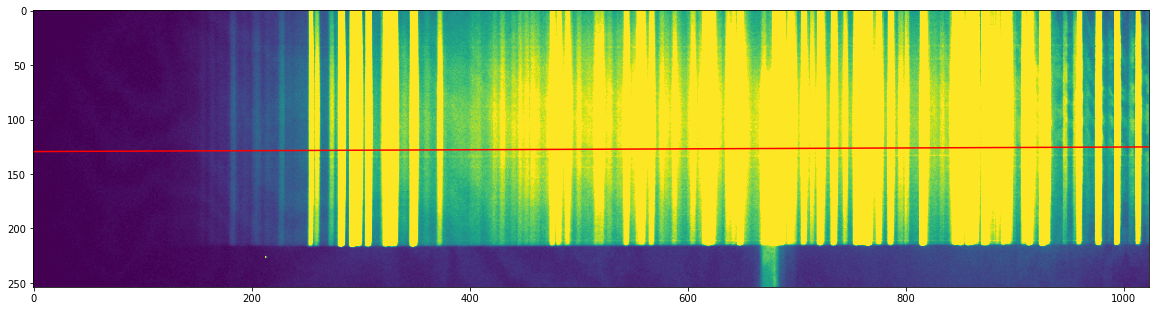

Using calib_data/Xe_lines.csv (Currently hardcoded!)


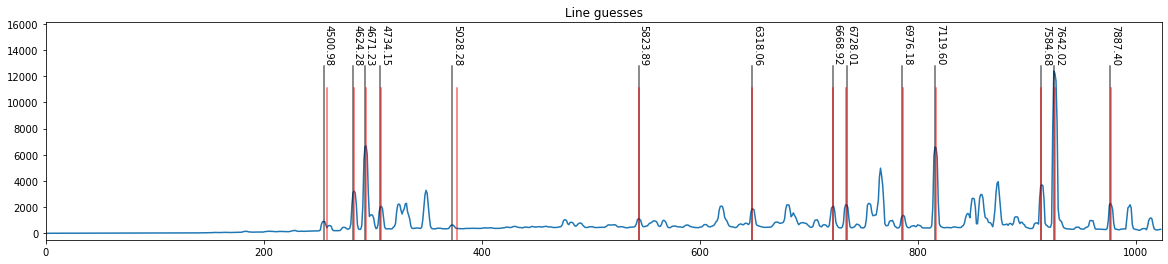

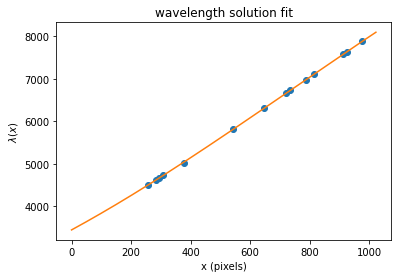

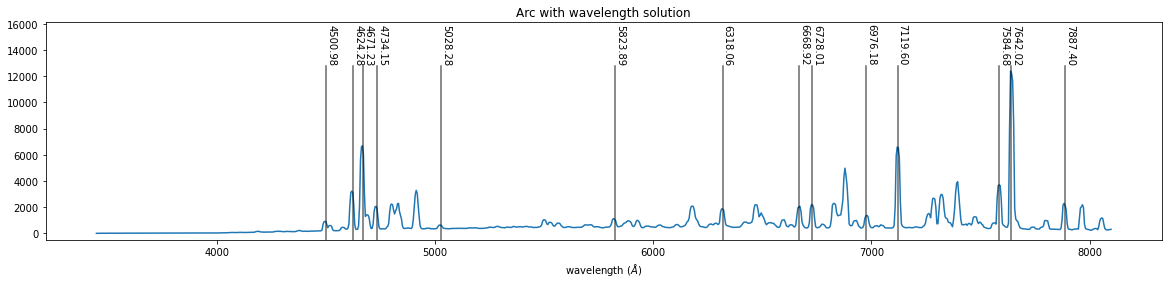

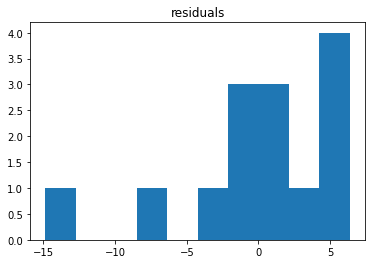

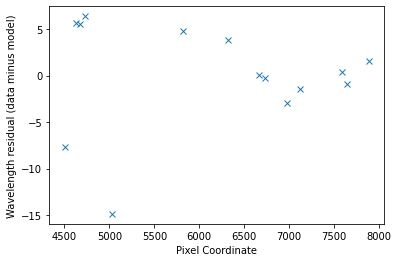

In [23]:
#Get the wavelength solution (This requires the arc that is taken immediately after the science exposure and the trace in the science exposure)
arc_frame = Path(f'InputSpectra/v_a_{files[w].name.split("_")[2]}_{1+int(files[w].name.split("_")[3])}_1_0_1.fits')
print(arc_frame)
wl = extract_wl(arc_frame, trace_mod, plot_result=True)

#### Compare found lines with this image to see if the wavelength solution is good (6318.06 is wrongly labeled, it should be the next one on the right side)
![title](calib_data/SPRAT_xenon_arc.png)

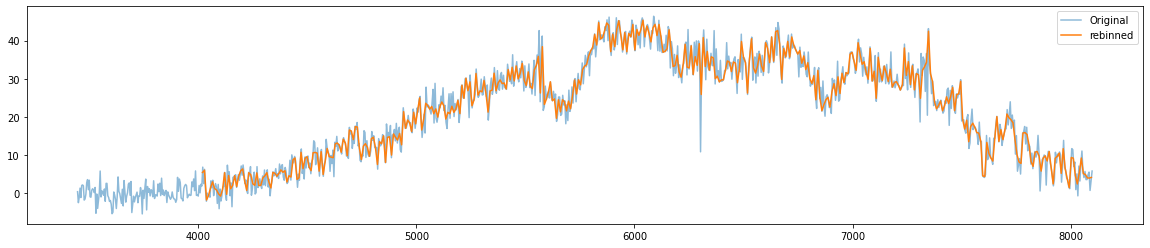

In [24]:
#Finally, rebin the spectrum to get the normal form
rebinned_spec, rebinned_wl = rebin_spec(extracted_spec, wl, plot_result=True)

In [25]:
#Flux calibrate and normalize spec
calib_spec = rebinned_spec*response_function/np.max(rebinned_spec*response_function)

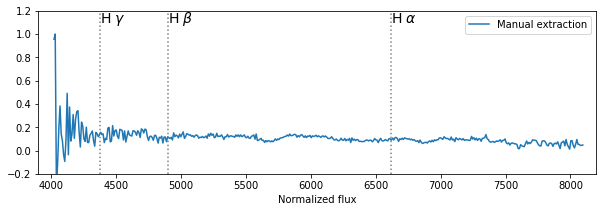

In [26]:
#Plot the spectrum and add line markers as desired
lines = [6563, 4861, 4341]
names = [r'H $\alpha$', r'H $\beta$', r'H $\gamma$']
z = 0.008

fig = start_fig(lines, names, z)
plt.plot(rebinned_wl, calib_spec, label='Manual extraction')
plt.legend()
plt.show()

### Further processing akin to Simon's QuickSPRATPipeline

Correcting flux for airmass 1.393748 using CorrectionFiles/1.4.txt


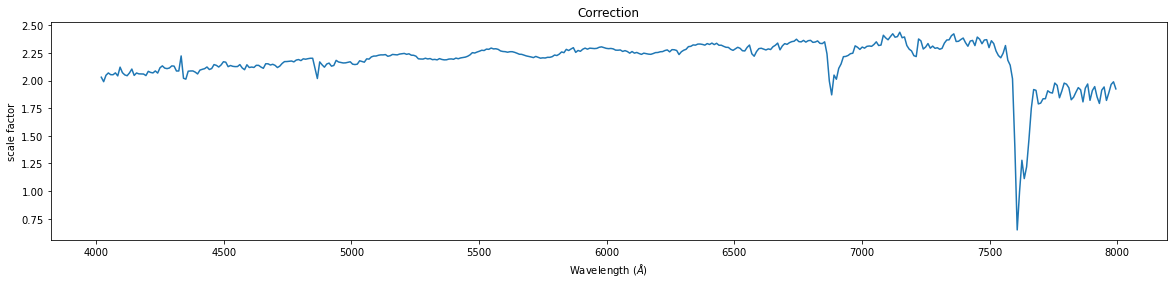

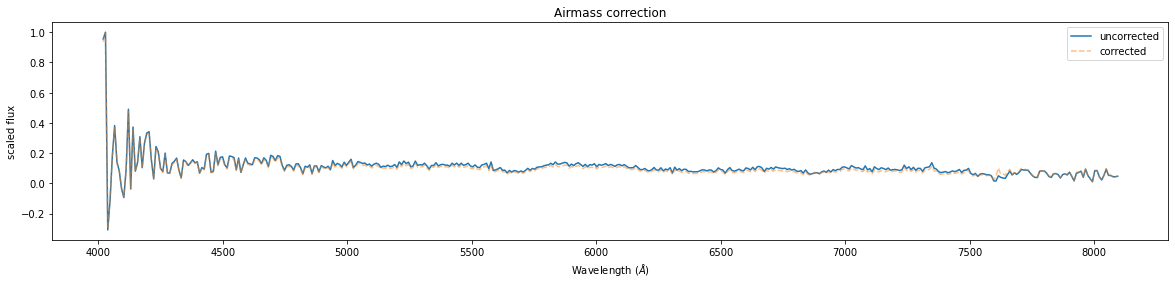

Name:		2024xmc
obsdate:	2024-10-13T05:35:25.232
mjd:		60596.232931
Saving in OutputSpectra/2024xmc_2024-10-13.w.text


In [27]:
#First put the spectrum in a pandas df for easy handling
spec_df = pd.DataFrame(np.array([rebinned_wl, calib_spec]).transpose(), columns=['wl', 'flux'])

#Choose whether airmass and/or cosmic ray correction should be applied before saving the result
#WARING: CR CORRECTION MAY ALSO REMOVE HOST LINES!!! (Already done a proper one in the 2D version anyway so normally not needed)
airmass_correction = True
cr_correction = False

#This also automatically saves the final result
final_processing(spec_df, hdul[0].header, airmass_correction, cr_correction, verbose=True)